In [149]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import scipy
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [150]:
map_genre = {
    "Humor/Family": "Humor/Family/Romance",
    "Self-Help": "Self-Help",
    "Suspense/Mystery": "Suspense/Mystery",
    "Fantasy/Adventure": "Fantasy/Adventure",
    "Biography/Historical": "Biography/Historical/Memoir",
    "Romance": "Humor/Family/Romance",
    "Horror/Thriller": "Horror/Thriller",
    "Memoir": "Biography/Historical/Memoir",
    "Poetry/Novel": "Miscellaneous",
    "Historical/Fiction": "Biography/Historical/Memoir",
    "Novel": "Miscellaneous",
    "Non-Fiction": "Miscellaneous",
    "Folklore": "Fantasy/Adventure",
    "Travel": "Biography/Historical/Memoir",
    "Adventure": "Fantasy/Adventure",
    "Novel/Feminism": "Miscellaneous",
    "Historical/Family": "Biography/Historical/Memoir",
    "Children's/Humor": "Humor/Family/Romance",
    "Magical Realism/Historical": "Biography/Historical/Memoir",
    "Fantasy/Horror": "Fantasy/Adventure",
    "Political/Dystopian": "Fantasy/Adventure",
    "Self-help/Management": "Self-Help",
    "Historical/Adventure": "Fantasy/Adventure",
    "Thriller/Suspense": "Suspense/Mystery",
    "War/Romance": "Miscellaneous",
    "Science fiction/Adventure": "Fantasy/Adventure",
    "Literary fiction/Humor": "Humor/Family/Romance",
    "Adventure/Travel": "Biography/Historical/Memoir",
    "Philosophy/Nature": "Miscellaneous",
    "Satirical/War": "Miscellaneous",
    "Existential/Philosophical": "Miscellaneous",
    "Fantasy/Humor": "Fantasy/Adventure",
    "Mystery/Suspense": "Suspense/Mystery",
    "Thriller/Adventure": "Fantasy/Adventure",
    "Family/Humor": "Humor/Family/Romance",
    "Adventure/Fantasy": "Fantasy/Adventure",
    "Science Fiction/Thriller": "Fantasy/Adventure",
    "Science Fiction/Adventure": "Fantasy/Adventure",
    "Fantasy/Romance": "Fantasy/Adventure",
    "Science Fiction/Humor": "Fantasy/Adventure",
    "Thriller/Mystery": "Suspense/Mystery",
    "Horror/Suspense": "Horror/Thriller",
    "Non-fiction": "Miscellaneous",
    "Fiction": "Miscellaneous",
    "Non-fiction/Historical": "Biography/Historical/Memoir",
    "Philosophy": "Miscellaneous",
    "Cookbook": "Miscellaneous"
}

In [151]:
bookdataset =  pd.read_csv('BookDataset.csv')

for key, value in map_genre.items():
    bookdataset.loc[bookdataset["final genre"] == key, "final genre"] = value

In [152]:
def create_regression_plot(X, Y, Y_pred, x_label, y_label, axs):
    axs.scatter(X, Y, color="blue")
    axs.plot(X, Y_pred, color="red", linewidth=2)
    axs.ticklabel_format(style='plain', axis='y', scilimits=(0, 0))
    axs.ticklabel_format(style='sci', axis='x',scilimits=(0, 0))
    axs.set_xlabel(x_label)
    axs.set_ylabel(y_label)

def perform_regression_analysis(X, Y):

    ## Now we perform linear regression and plot it:
    r_model = linear_model.LinearRegression()

    ## Train the model to see the relation
    r_model.fit(X, Y)

    ## Predict the number of reviews
    predict_reviews_nums = r_model.predict(X)

    ## Mean square error
    print("Mean squared error: %.2f" % mean_squared_error(Y, predict_reviews_nums))

    ## r2_score
    print("R2 score: %.2f" % r2_score(Y, predict_reviews_nums))
    
    ## Weight of linear regression
    m = r_model.coef_
    ## Intersept of the line
    c = r_model.intercept_

    return predict_reviews_nums

In [159]:
# bookdataset =  pd.read_csv('BookDataset.csv')

ratings = bookdataset[['RatingDist5', 'RatingDist4', 'RatingDist3', 'RatingDist2',
       'RatingDist1']]
number_of_ratings = bookdataset[['RatingDistTotal']].to_numpy().reshape(-1,1)

## Perform regression analysis by taking standard deviation of ratings as "Controversy Score"
def do_std_dev_analysis(ratings, number_of_ratings, plot_axs, plot_enable=False):
    ratings_std_dev = np.std(ratings, axis=1).to_numpy().reshape(-1,1)
    predictions = perform_regression_analysis(ratings_std_dev, number_of_ratings)
    
    if(plot_enable):
        create_regression_plot(ratings_std_dev, number_of_ratings, predictions, "Standard deviation of ratings -->", "Number of ratings -->", plot_axs)

## Perform regression analysis by taking difference between mean and median of ratings as "Controversy Score"  
def do_mean_median_analysis(ratings, number_of_ratings, plot_axs, plot_enable=False):
    ratings_median = np.median(ratings, axis=1).reshape(-1,1)
    ratings_mean = np.mean(ratings, axis=1).to_numpy().reshape(-1,1)

    ratings_diff = abs(ratings_median - ratings_mean)

    predictions = perform_regression_analysis(ratings_diff, number_of_ratings)
    
    if(plot_enable):
        create_regression_plot(ratings_diff, number_of_ratings, predictions,"||Mean - Median|| -->", "Number of ratings -->", plot_axs);


## Perform regression analysis by taking ratio of 5 star to 1 star as "Controversy Score"
def do_ratio_analysis(ratings, number_of_ratings, plot_axs, plot_enable=False):
    ratings_np = ratings.to_numpy()
    ratio_5_1 = (ratings_np[:,0] / ratings_np[:,4]).reshape(-1, 1)
    predictions = perform_regression_analysis(ratio_5_1, number_of_ratings)
    
    if(plot_enable):
        create_regression_plot(ratio_5_1, number_of_ratings, predictions, "Ratio of 5star to 1star -->", "Number of ratings -->", plot_axs)


Mean squared error: 59938014756.63
R2 score: 0.90


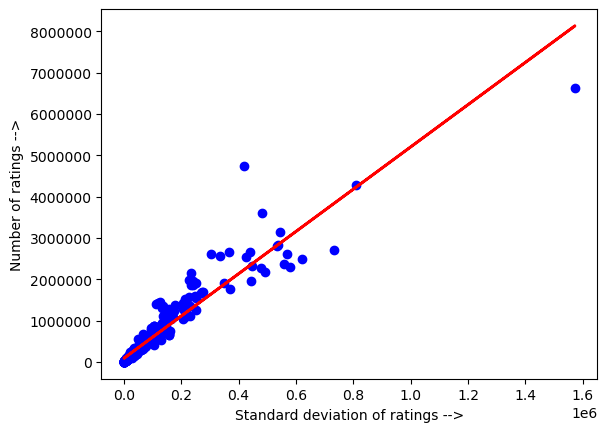

In [154]:
fig, axs = plt.subplots()
do_std_dev_analysis(ratings, number_of_ratings, axs, True)

Mean squared error: 237766736933.68
R2 score: 0.59


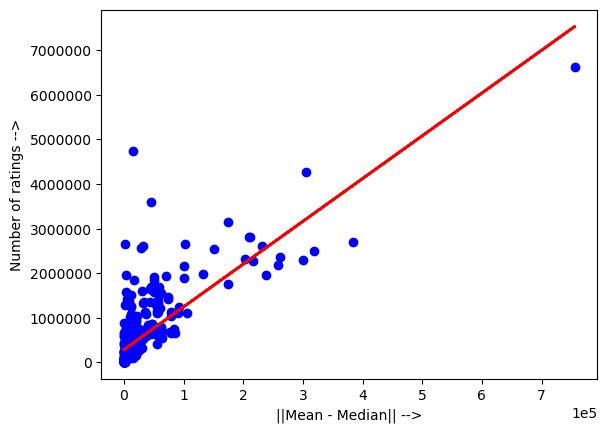

In [147]:
fig, axs = plt.subplots()
do_mean_median_analysis(ratings, number_of_ratings, axs, True)

Mean squared error: 576395305090.11
R2 score: 0.01


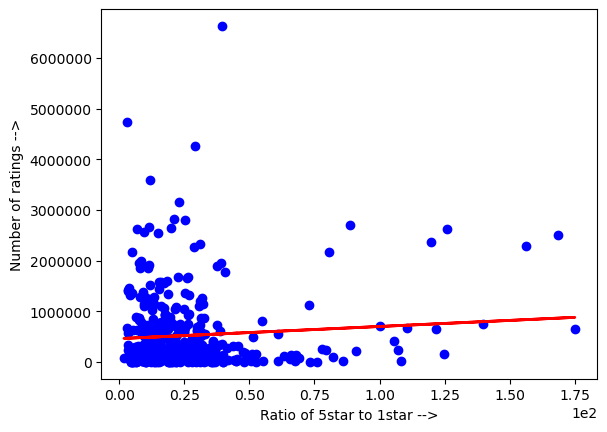

In [148]:
fig, axs = plt.subplots()
do_ratio_analysis(ratings, number_of_ratings, axs, True)

In [158]:
## Per genre analysis. We only plot std-deviation as it gives best relations

unique_values = bookdataset["final genre"].unique()


for genre in unique_values:
    dataSubset = bookdataset.loc[bookdataset["final genre"] == genre]
    ratings_subset = dataSubset[['RatingDist5', 'RatingDist4', 'RatingDist3', 'RatingDist2',
       'RatingDist1']]
    number_of_ratings_subset = dataSubset[['RatingDistTotal']].to_numpy().reshape(-1,1)

     Unnamed: 0                                               Name  \
0             0                  Ramona's World (Ramona Quimby #8)   
2             2                                  Imogene's Antlers   
12           12                                    The Blue Bistro   
13           13  The Little Old Lady Who Was Not Afraid of Anyt...   
20           20          A Bear Called Paddington (Paddington, #1)   
..          ...                                                ...   
375         375           Brown Bear, Brown Bear, What Do You See?   
378         378                    Who's Afraid of Virginia Woolf?   
381         381  Cloudy With a Chance of Meatballs (Cloudy with...   
392         392                               A Light in the Attic   
394         394                            The Wind in the Willows   

              Authors  Rating        ISBN  PublishYear  RatingDist5  \
0      Beverly Cleary    4.11  0688168167         2020         4367   
2         David S